# **MolecularDynamicsPBC class**

The aim of this notebook is to ilustrate all the functionalities of the `MolecularDynamicsPBC` class and explain some the model's features.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from molecular_dynamics import MolecularDynamicsPBC

from IPython.display import Video

In [2]:
model_params = { 
    'box_width' : 20,
    'gas_density' : 0.25,
    'time_step' : 5e-3,
    'initial_temperature' : 1.
}


model = MolecularDynamicsPBC(**model_params)

## 1 - The model

### 1.1 - Interaction potential

Here we will consider a set of $N$ *classical* particles of mass $m$ that interact pair-wise via the Lennard-Jones potential and moving according Newton's laws in two dimensions. The Lennard-Jones potential is given by 

$$
V(r_{ij}) = 4\epsilon\left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right],
$$

where $r_{ij} = r_{ji}$ is the Euclidean distance between the particles $i$ and $j$, $\epsilon$ is the strength of the potential and $\sigma$ is a length scale. 

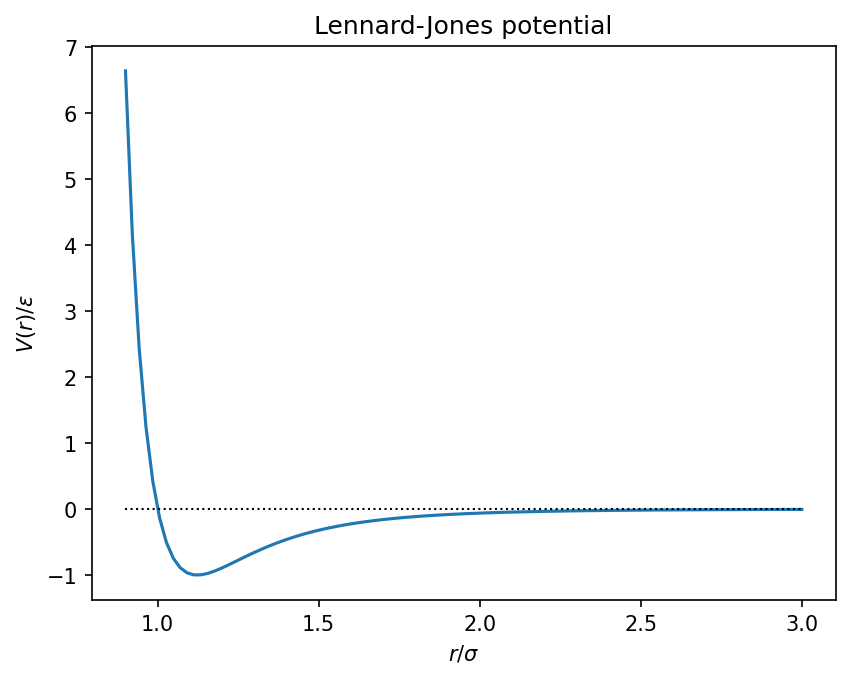

In [3]:
def v(x): 
    """Function that returns the Lennard-Jones potential"""
    return 4./(x**12) - 4./(x**6)

x = np.linspace(0.9, 3, 100)

fig = plt.figure(dpi = 150)
plt.plot(x, v(x))
plt.plot(x, 0*x, color = 'black', linestyle = 'dotted', linewidth = 1)
plt.title("Lennard-Jones potential")
plt.xlabel('$r/\\sigma$')
plt.ylabel('$V(r)/\\epsilon$')

plt.show()

We see from the shape of the Lennard-Jones potential above that for long distances, i.e. for $r \gtrsim \sigma$, the potential is attractive, while for $r \lesssim \sigma$ the potential is strongly repulsive. The potential also has a minimum at $r_0 = 2^\frac{1}{6}\sigma$, where $V(r_0) = -\epsilon$.

This potential is a good model for inert gases, like ideal gases, that cannot for chemical bonds, i.e. cannot exchange electrons. The $\left(\frac{\sigma}{r}\right)^6$ tail models dipole interactions that are produce by the interaction of the molecules electronic clouds via the electrostatic force, that distorts the clouds, attractive producing electric dipole forces. The $\left(\frac{\sigma}{r}\right)^{12}$-term models the strong repulsion that appears out of the superposition of the molecules electronic clouds, and it is produced by Pauli's exclusion principle. This principle express the empirical fact that two electrons cannot occupy the same state.  

### 1.2 Boundary conditions

For simplicity, we will consider periodic boundary conditions. This means that in a lattice of size $L$, if the particle moves to a position $x = L + a$, the particle is the moved to the position $x' = x - L = a$, assuming here $a < L$. Hence, if the particles leaves the lattice on the right, it reappears on the left. And vice-versa. If the particle moves to the position $x = a < 0$, then it is moved to the position $x' = a + L < L$.

This choice of boundary conditions have some advantages. In a real gas we typically have $N \sim 10^{23}$ particles, which would be very costly to simulate in a computer. For small set of particles, say $N \sim 100$, assuming the the boundary of the lattice are hard walls as in a vessel might produce undesirable boundary effects that one would not find in real-life situations. The periodic boundary condition then allows us to simulate the situation in which we are observing a sample of the bulk of the gas, away from the vessel walls at a constant density 

## 2 - Numerical Method

To numerically compute the position of the gas molecules, we will use the so-called **Verlet method**, see e.g. *Computational Physics* by N. Giordano. This method is suitable when the interaction potential does not depend on the velocity. Moreover it is a method easy to implement and has good numerical precision.

Let us consider a function $y(t)$ satisfy the equation of motion $\frac{d^2y(t)}{dt^2} = f[y(t)]$ and its Taylor expansion going forward and backward in time around the instant $t_i$ with a time step $\Delta t$,

$$
y(t_i + \Delta t) = y(t_i) + \Delta t\frac{dy(t_i)}{dt} + \frac{1}{2}\Delta t^2\frac{d^2y(t_i)}{dt^2} + \frac{1}{6}\Delta t^3\frac{d^3y(t_i)}{dt^3} + O(\Delta t^4)
$$
and
$$
y(t_i - \Delta t) = y(t_i) - \Delta t\frac{dy(t_i)}{dt} + \frac{1}{2}\Delta t^2\frac{d^2y(t_i)}{dt^2} - \frac{1}{6}\Delta t^3\frac{d^3y(t_i)}{dt^3} + O(\Delta t^4).
$$

Denoting $y_i \equiv y(t_i)$, $y_{i-1} \equiv y(t_i - \Delta t)$, $y_{i+1} \equiv y(t_i + \Delta t)$ and $f(y) = $, we have that

$$
y_{i + 1} = 2 y_i - y_{i - 1} + \Delta t^2f(y_i) + O(\Delta t^4),
$$

hence the error is of order $O(\Delta t^4)$. The Verlet method is thus approximates $\frac{d^2y}{dt^2}$ symmetrically using differences centered at the instant $t_i$ with high accurate. We can also obtain the velocity $v_i = \frac{dy_i}{dt}$ from the Verlet method by taking

$$
y_{i+1} - y_{i-1} = 2\Delta t v_i + O(\Delta t^3)\;\;\;\; \rightarrow \;\;\;\; v_i = \frac{y_{i+1} - y_{i-1}}{2\Delta t} + O(\Delta t^3).
$$

## 3 - Initial conditions

For the initial condition, e assume that the gas has a fixed density $\rho$, with its molecules starting on the vertices of a square lattice of side $L$ and cell size $d = L/\sqrt{\rho}$. We give the option of adding a random displacement. If `random_initial_position = True`, a value $s = \alpha d$ is added both in the $x$- and $y$-directions, with $\alpha$ random variable homogeneously distributed in the interval $[-0.25, 0.25]$. 

For the velocity $\vec{v}$, we assume that $v_x$ and $v_y$ components are Gaussian random variables with zero mean and variance $kT_\textrm{init}$, i.e. the initial temperature.

In [4]:
model.generate_initial_conditions(random_initial_position = True)

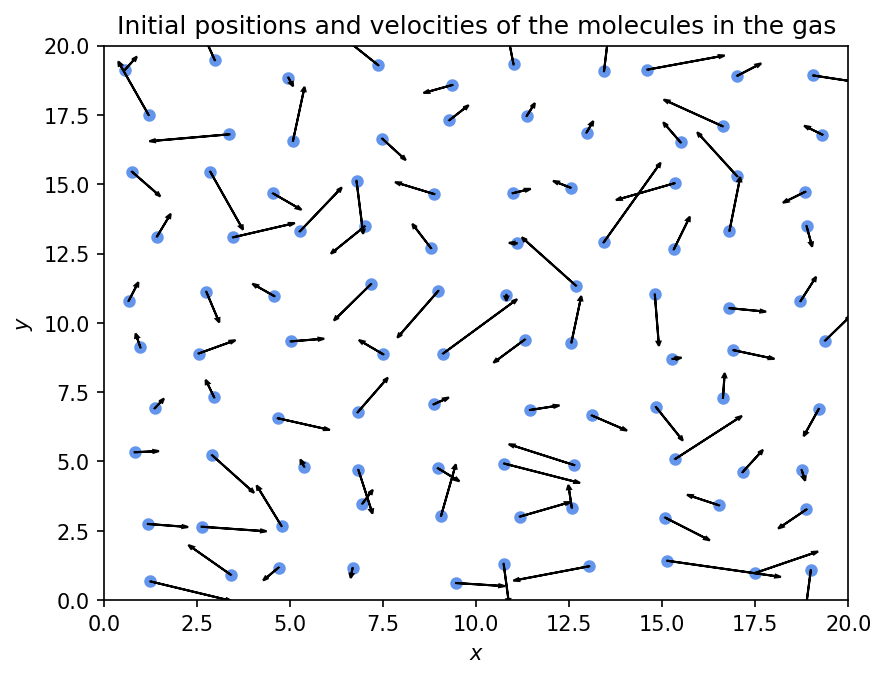

In [5]:
model.plot_initial_conditions()

*Example of initial condition in a lattice of side $L = 20$, with the arrows displaying the initial velocities of the molecules. The density was assumed $0.25$.*

Given the initial positions and velocities of the molecules, we compute the positions at the previous step, needed to start the Verlet method, by simply taking the positions for the $i$-th molecule at the step as

$$
y_i(t_{-1}) = y_i(t_0) - v_i(t_0)\Delta t.
$$

## 4 - Forces

The expression for the interaction force between two particles is

$$
\vec{F}(\vec{x} - \vec{x}') = \frac{24 \epsilon}{\sigma}\left[2\left(\frac{\sigma}{r}\right)^{13} - \left(\frac{\sigma}{r}\right)^7\right]
\frac{\vec{x} - \vec{x}'}{r} 
$$

with $r = \| \vec{x} - \vec{x}'\|$. 

To simplify the numerical computation we will only consider the interaction between molecules that are apart by up to a distance of $3\sigma$. This introduces an error in the computation of force of the order $1/3^7 \sim 10^{-4}$. Hence, if we choose $\Delta t \sim 10^{-3}$, the error in the equation for the position is still consistent with the error in the equation for the velocity.

We also need to take into account the periodic boundary condition when computing the force so the reappearance of a molecule on the other side of the lattice is consistent with the dynamics. This is accomplished by computing the shortest distance between two molecules and using it to compute the force between them. Hence, suppose two molecules $i$ and $j$ at positions $x_i$ and $x_j$. If their coordinate distance is less than $L/2$, then we simply use $x_i - x_j$, otherwise we have to use the complement of the coordinate distance given by $x_i - x_j - \textrm{sgn}(x_i - x_j)L$. 

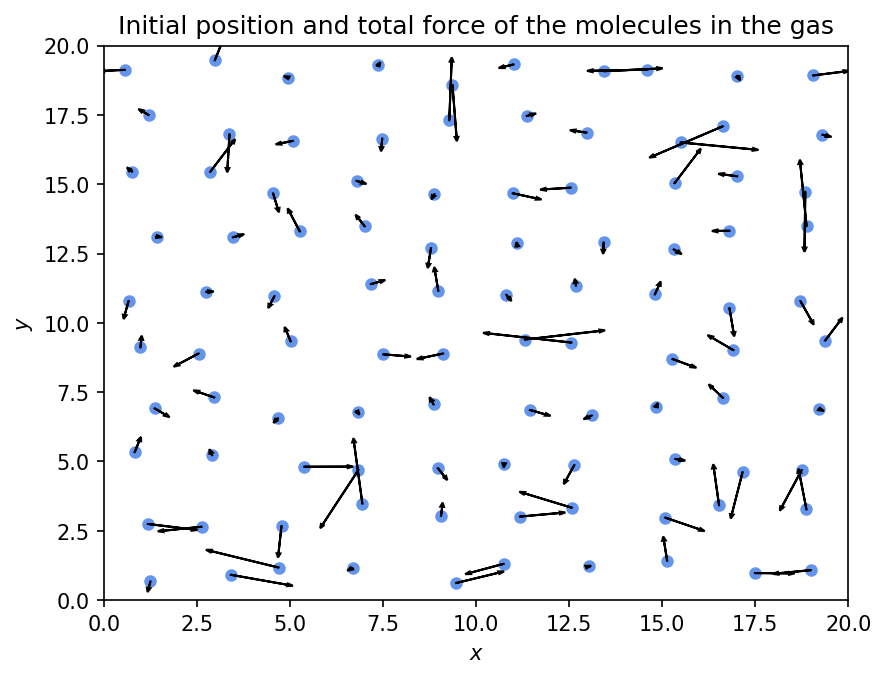

In [6]:
model.plot_initial_forces()

*Example of initial condition in a lattice of side $L = 20$, with the arrows now displaying the initial total forces on the molecules. The density was assumed $0.25$.*

## 5 - Dynamics

The dynamics is then generated after setting the initial conditions by iterating the methods outlined above by a number of `total_time_steps` steps. Below is the animated result for the molecule's positions. 

In [7]:
model.generate_dynamics(total_time_steps = 6000)

In [8]:
model.generate_gas_animation()
Video("molecular_dynamics.mp4")

*Example of the animation of the gas molecule's movement in a 2D volume of side $L = 20$. The density was assumed $0.25$. and the initial temperature $kT_\textrm{init} = 1.$*

## 6 - Statistical measurements

### 6.1 - Maxwell-Boltzmann distribution

Here we will consider an ideal gas, i.e. a gas whose the energy of the interaction between the molecules is negligible when compared to the kinetic energy. This is done by choosing the molecules initial state such that their separation is $\sim \sigma$ and initial temperature sufficiently  high. Note that the initial state will not correspond to a thermal equilibrium state, so the collisions between the particles are still important to take the system to equilibrium.

Hence, let us assume that our system is well approximated by an ideal gas. Since the probability of finding the gas in a state with energy between $E$ and $E + dE$ is given $p(E)dE \propto \textrm{e}^{-\frac{E}{kT}}dE$, where $k$ is Boltzmann's constant and $T$ the temperature. For an ideal gas the particles are independent from each other and the energy is the kinetic energy, $E = \frac{1}{2}mv^2$. Hence, the probability of finding an atom with velocity modulus between $v$ and $v + dv$ in 2 spatial dimensions is  

$$
\eqalign{
p(E)dE & \propto \exp{\left(-\frac{m}{2kT}v^2\right)}\vec{v}\cdot d\vec{v} \cr 
& \propto v\exp{\left(-\frac{m}{2kT}v^2\right)}dv.
}
$$
The normalised probability distribution for the velocity modulus then is
$$
f(v)dv = \frac{m}{kT} v \exp{\left(-\frac{m}{2kT}v^2\right)}dv,
$$
the Maxwell-Boltzmann distribution.

In [9]:
model.generate_velocity_distribution()

The `generate_velocity_distribution` method generates the instantaneous **velocity modulus** distribution as a histogram, i.e. it generates the velocity distribution histogram for each time step.

The `generate_velocity_distribution_animation` animates the velocity modulus distribution by averaging it over time for a certain number of time steps set by the parameter `average_window`. The average histogram $\langle \textrm{hist}_i\rangle$ at the step $i$ is given by

$$
\langle \textrm{hist}_i\rangle =\frac{1}{\min(N_\textrm{aw},i)}\sum_{j = 0}^{\min(N_\textrm{aw}, i)}\textrm{hist}_{i - j},
$$

where $N_\textrm{aw}$ is the averaging window, in number of time steps.


For a small sample of molecules, averaging over a certain time window mitigates the statistical fluctuations. 

In [10]:
model.generate_velocity_distribution_animation(average_window = 3000)
Video("velocity_distribution.mp4")

*Example of the animation of the gas molecule's velocity modulus distribution in a 2D volume of side $L = 20$. The density was assumed $0.25$. and the initial temperature $kT_\textrm{init} = 1.$*

### 6.2 - Measuring $kT$

**Fitting methods:** To measure the temperature of our gas once it reaches thermal equilibrium, we can measure the velocity modulus distribution and then fit the resulting curve. For the fitting, we notice that for the discrete probability distribution $g(v)$ we have

$$
\ln g(v) = \ln\left(\frac{m\Delta v^2}{kT}\right) + \ln \left(\frac{v}{\Delta v}\right) - \frac{m}{2kT}v^2,
$$

and thus

$$
\ln\left(\frac{g(v)\Delta v}{v}\right) = \ln\left(\frac{m\Delta v^2}{kT}\right) - \frac{m}{2kT}v^2,
$$

where $\Delta v$ is the finite size of the velocity bins. Thus, we can simply use a linear regression, after a log-log transformation of the velocity distribution. Note that since $kT$ appears both in the constant and slope coefficients, average the values of $kT$ obtained from each term. Thus, for

$$
\ln\left(\frac{\tilde{g}(v)\Delta v}{v}\right) = a_0 + a_1v^2,
$$

we have that

$$
kT_\textrm{measured} = \frac{m\Delta v^2}{2} \textrm{e}^{a_0} - \frac{a_1}{m}.
$$


For a small system such as the ones we are able to simulate, there will be a considerable amount of statistical fluctuation in the velocity modulus populations. A way to counter-balance these fluctuations is to average the velocity distribution over time. The `measure_kT` method gives the option to fit the instantaneous velocity distribution at the final time step if `method = 'intantaneous fitting'` or the time averaged velocity distribution for a certain time window ending at the final time step if `method = 'averaged fitting'` and `average_window` is the average time window. 

Measured kT after 6000 steps from fitting: 1.4924203435374617
 


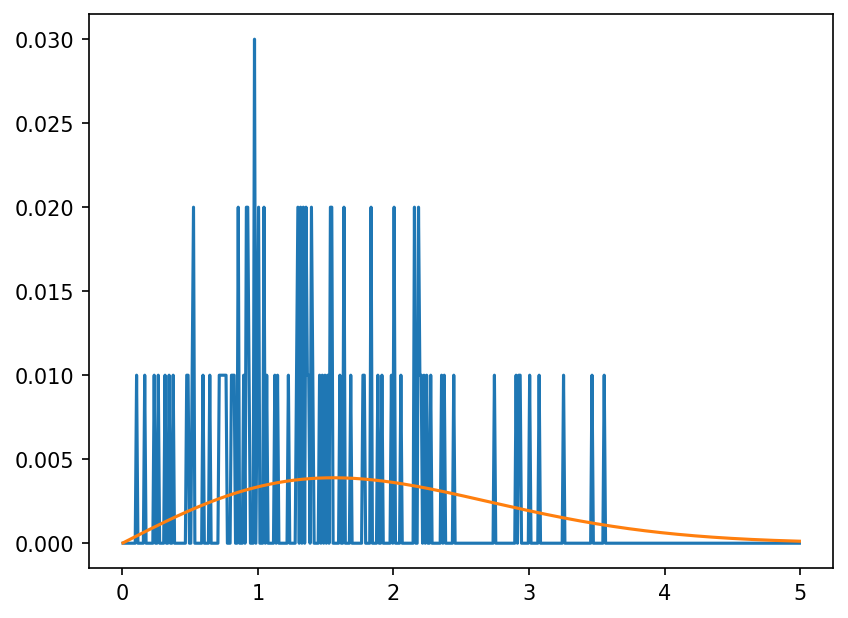

In [11]:
model.measure_kT(method = "instantaneous fitting")

Measured kT after 6000 steps from fitting: 1.2179315971745885
 


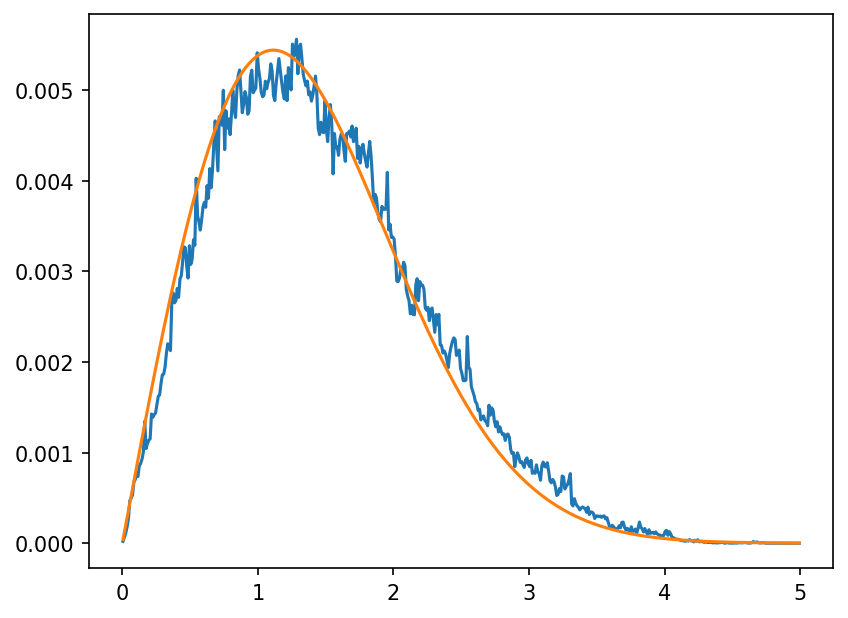

In [12]:
model.measure_kT(method = "averaged fitting", average_window = 6000)

**Equipartition:** Another possibility is to use the equipartition theorem, where each degree of freedom corresponds to $\frac{1}{2}kT$ in the mean energy. For a free particle in 2 dimension, we have that

$$
\left\langle E \right\rangle = kT
$$

and

$$
kT = \frac{m}{2}\left\langle v^2 \right\rangle. 
$$

Thus an alternative way to measure the temperature is to measure the mean of the squared velocity at the final time step.

In [13]:
model.measure_kT(method = "equipartition")

Measured kT after 6000 steps from the equipartition theorem: 1.3311125677545468


It is interesting to notice that all the temperature measurements return a $kT$ that is higher than the value set up at the initial conditions. This is due to the energy coming from the potential energy.

## 7 - Thermostat

It is also possible to "change the temperature" of the gas. Here we have implemented the simplest form of a thermostat: the velocity rescaling thermostat. Given old and new temperatures, $kT_\textrm{old}$ and $T_\textrm{new}$, we define the rescaling factor $\gamma$ as

$$
\gamma  = \sqrt{\frac{kT_\textrm{new}}{kT_\textrm{old}}}.
$$

We then rescale the molecular velocity at the $i$-th step as

$$
\vec{v}_i\;\;\to\;\; \gamma \vec{v}_i.
$$

After rescaling of the molecular velocity at the step $i$, for a molecule at position $\vec{x}_i$ at step $i$ its position at the step $i - 1$ has to be updated by

$$
\vec{x}_{i - 1} \;\;\to\;\; \vec{x}_i - \gamma(\vec{x}_i - \vec{x}_{i-1}).
$$

These changes set new initial conditions that the method `change_temperature` uses to evolve the gas for an extra number of time steps set by the parameter `extra_time_steps`. 


In [14]:
change_temperature_params = {"new_temperature" : 10.,
                            "extra_time_steps": 6000}

model.change_temperature(**change_temperature_params)

In [15]:
model.generate_gas_animation()
Video("molecular_dynamics.mp4")

*Example of the animation of the gas molecule's movement in a 2D volume of side $L = 20$. The density was assumed $0.25$, the initial temperature $kT_\textrm{init} = 1.$ and the temperature is raised to $kT = 10.$*

It is interesting to also visualise the change in temperature by looking at what happens with the velocity modulus distribution over time.  

In [16]:
model.generate_velocity_distribution()

In [17]:
model.generate_velocity_distribution_animation(average_window = 3000)
Video("velocity_distribution.mp4")

*Example of the animation of the gas molecule's velocity modulus distribution in a 2D volume of side $L = 20$. The density was assumed $0.25$, the initial temperature $kT_\textrm{init} = 1.$ and the temperature is raised to $kT = 10.$*

We can also measure the final temperature using the `measure_kT` method.

Measured kT after 11999 steps from fitting: 3.806968121336311
 


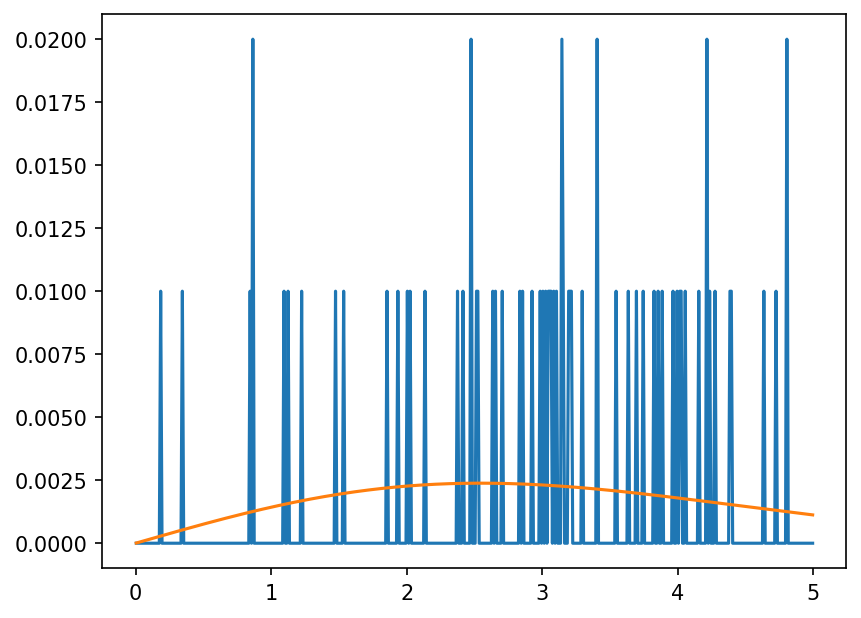

In [18]:
model.measure_kT(method = "instantaneous fitting")

Measured kT after 11999 steps from fitting: 11.040121030586938
 


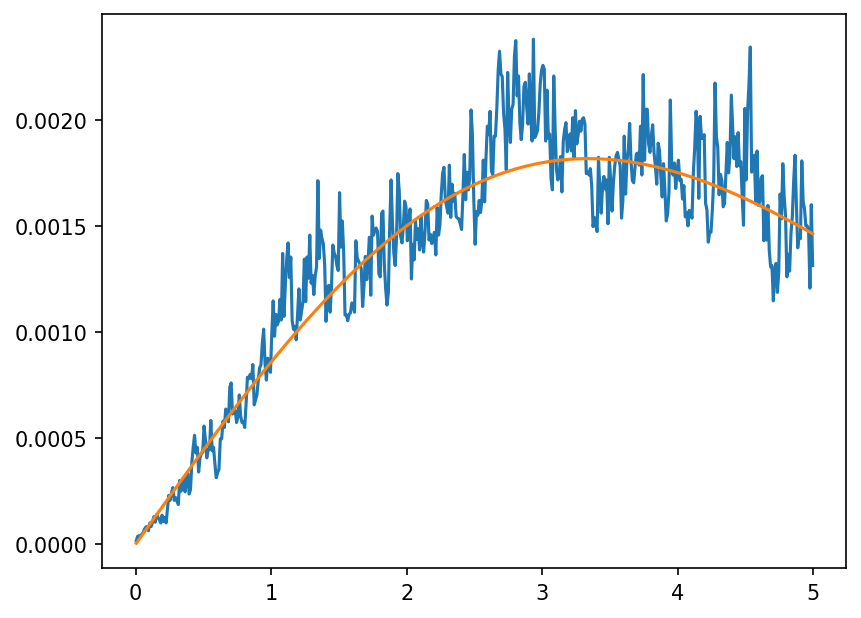

In [19]:
model.measure_kT(method = "averaged fitting", average_window = 3000)

In [20]:
model.measure_kT(method = "equipartition")

Measured kT after 11999 steps from the equipartition theorem: 10.270223908530047


We see that the last to ways to measure the final temperature are close to the value we set for the new temperature.

## 8 - Pressure

Since we do not have physical hard walls in your system, we consider an imaginary perfectly reflective wall. Then for the time step $i$, we consider all the molecules close enough, $\le 0.25$ in the $x$-direction, if the imaginary wall runs along the $y$-direction. For these molecules, the total momentum exchange with a reflective all is

$$
\Delta p^\textrm{one side}_{x,\, i} = \sum_{j = 0}^{N^\textrm{one side}_\textrm{molecules}}2 m |v^{(j)}_{x,\, i}|.
$$

Now, if we are considering molecules hitting the imaginary wall from both sides so to increase the number of samples, the total pressure exerted over the wall is

$$
P_i = \frac{1}{2}\frac{|\Delta p^\textrm{one side}_{x,\, i}|}{\Delta t L} + \frac{1}{2}\frac{|\Delta p^\textrm{other side}_{x,\, i}|}{\Delta t L} = \sum_{j = 0}^{N^\textrm{both sides}_\textrm{molecules}} m \frac{|v^{(j)}_{x,\, i}|}{\Delta t L},
$$

where $L$ is the linear size of the wall.

Average pressure after 11999: 24.720693281039075


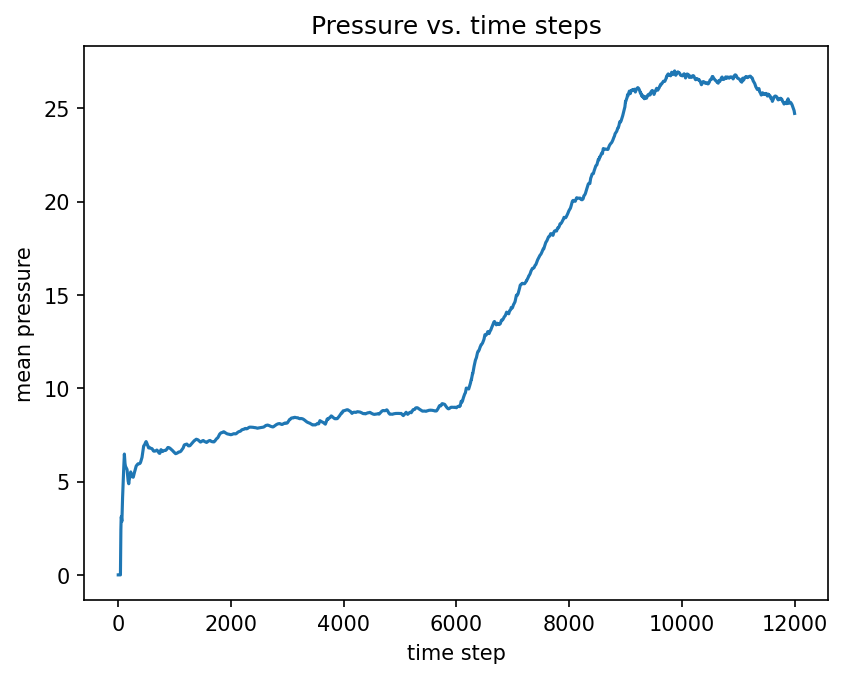

In [21]:
model.measure_pressure(average_window = 3000)

*Example of the averaged gas pressure in a 2D volume of side $L = 20$. The density was assumed $0.25$, the initial temperature $kT_\textrm{init} = 1.$ and the temperature is raised to $kT = 10.$ after $6000$ time steps*

We see that as the temperature rises, so does the pressure, as expected on physical grounds.

## 9 - Brownian movement

We demonstrate the Brownian movement by considering a second molecule species with mass and size scaled by the mass and size of the gas molecules. For the Brownian motion we consider a heavier and larger molecule.

In [22]:
model_params = { 
    'box_width' : 20,
    'gas_density' : 0.25,
    'time_step' : 5e-3,
    'initial_temperature' : 1.,
    'n_brownian_particles' : 1,
    'brownian_particle_mass' : 15,
    'brownian_particle_size' : 1.8,
}


model = MolecularDynamicsPBC(**model_params)

We again generate an initial conditions, with the initial position of the Brownian particle chosen randomly.

In [34]:
model.generate_initial_conditions(random_initial_position = True)

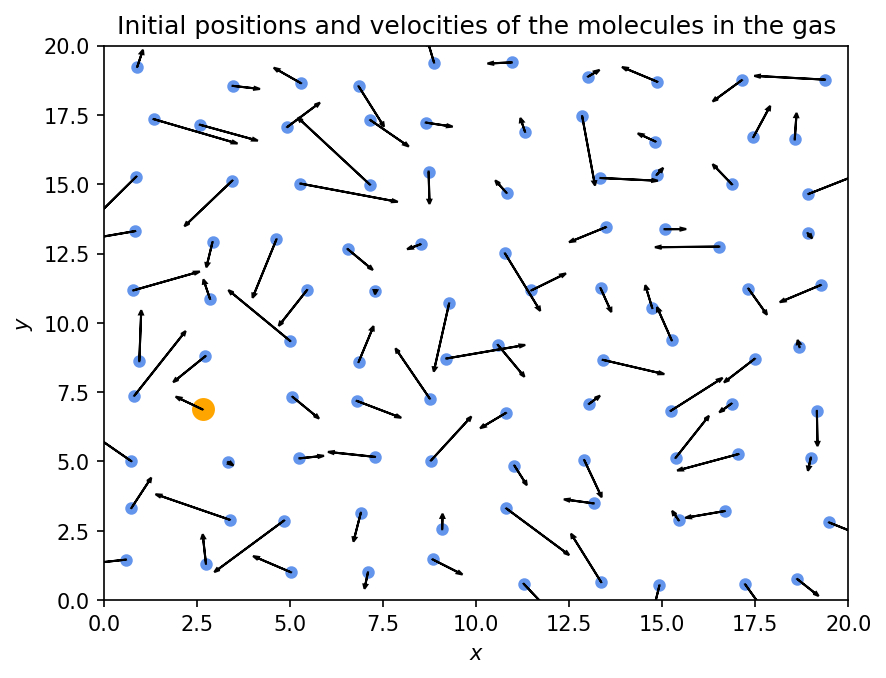

In [35]:
model.plot_initial_conditions()

*Example of initial condition in a lattice of side $L = 20$ and one Brownian particle (shown in orange) with the arrows displaying the initial velocities of the molecules. The density was assumed $0.25$. and initial temperature $kT_\textrm{init} = 1.$*

We then generate the dynamics with this Brownian particle.

In [36]:
model.generate_dynamics(total_time_steps = 6000)

In [37]:
model.generate_gas_animation(exit_file_name = "brownian_motion.mp4")
Video("brownian_motion.mp4")

*Example of the animation of the gas molecule's movement in a 2D volume of side $L = 20$ and one Brownian particle (shown in orange) with the arrows displaying the initial velocities of the molecules. The animation shows the Brownian particle track (line in beige). The density was assumed $0.25$. and initial temperature $kT_\textrm{init} = 1.$*